In [1]:
# load in melanoma/lung, map cancer stage to ordinal scale, identify correlating RNA expressions
# MIC, Pearson, Spearman, Distance correlation, monotonic_alignment, pca/fa

import omic_helpers
import random
import numpy as np
import scipy as sc
import pandas as pd
import vaex as vx
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import LocallyLinearEmbedding as LLE, Isomap
from sklearn.decomposition import PCA

import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
from tqdm import tqdm
plotly.offline.init_notebook_mode(connected=True)
cm = sns.light_palette("green", as_cmap=True)

import sys, os, gc
from collections import defaultdict

#from numba import jit

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [ ]:
def plot3d(xlist, title="", names=[]):
    fig = go.Figure(layout={'title': title})
    for idx, x in enumerate(xlist):
        name = names[idx]
        fig.add_trace(go.Scatter3d(
            x=x[:,0],
            y=x[:,1],
            z=x[:,2],
            mode='markers',
            marker={
                'size': 9,
                'opacity': 0.25,
            },
            name=name
        )
        )
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    plotly.offline.iplot(fig)
    
def iterative_correlator(X, min_corr=0.5, metric='cosine', axis=1):   
    ir = []; jr = []; vr = []
    ran = X.shape[1-axis]
    for c1 in tqdm(range(ran)):
        for c2 in range(ran): 
            distance = 1-sc.spatial.distance.cdist(X[:,c1:c1+1].T, 
                                                   X[:,c2:c2+1].T,
                                                   metric)[0][0]
            if abs(distance)>min_corr:
                ir.append(c1)
                jr.append(c2)
                vr.append(distance)
    scorr = sc.sparse.coo_matrix((vr, (ir,jr)),
                                 shape=(X.shape[1-axis], 
                                        X.shape[1-axis]))
    return scorr, ir, jr

In [2]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression/hackathon_2')

In [3]:
ctype='Lung'
include_alt_corrs = False

In [4]:
ds = {}
ds['RNAex'] = pd.read_csv(ctype+'/'+ctype+'_GeneExpression.txt', sep='\t')

In [5]:
methylation = pd.read_csv(ctype+'/'+ctype+'_Methylation.txt', sep="\t")
methylation_meta = pd.read_csv(ctype+'/HumanMethylation450_meta.csv', sep="\t")

In [84]:
proteome

,sample,TCGA-44-7670-01,TCGA-44-5644-01,TCGA-55-6979-01,TCGA-73-7498-01,TCGA-78-7148-01,TCGA-05-4422-01,TCGA-49-4506-01,TCGA-35-4123-01,TCGA-93-7348-01,TCGA-55-7728-01,TCGA-50-5932-01,TCGA-05-4417-01,TCGA-44-7659-01,TCGA-78-7155-01,TCGA-55-5899-01,TCGA-73-4675-01,TCGA-97-7941-01,TCGA-49-6742-01,TCGA-44-5643-01,TCGA-44-2657-01,TCGA-78-7152-01,TCGA-75-6212-01,TCGA-86-7954-01,TCGA-78-7146-01,...,TCGA-NC-A5HO-01,TCGA-77-A5FZ-01,TCGA-98-A53A-01,TCGA-33-AASI-01,TCGA-85-A4JB-01,TCGA-NK-A5CR-01,TCGA-O2-A52Q-01,TCGA-85-A512-01,TCGA-85-8353-01,TCGA-85-8072-01,TCGA-63-A5MJ-01,TCGA-37-A5EN-01,TCGA-77-8154-01,TCGA-63-A5ML-01,TCGA-56-A5DS-01,TCGA-NC-A5HJ-01,TCGA-58-8391-01,TCGA-85-A4PA-01,TCGA-34-8454-01,TCGA-85-A5B5-01,TCGA-85-A510-01,TCGA-77-A5G1-01,TCGA-NC-A5HN-01,TCGA-96-A4JL-01,TCGA-85-A4QQ-01
0,14-3-3_beta-R-V,0.205788,-0.063605,-0.120629,0.026592,0.085083,-0.219157,0.360702,0.048313,0.425879,0.209341,0.102673,-0.052266,0.343950,0.004106,0.003073,-0.145047,0.312102,0.096083,-0.175520,0.042174,0.245268,0.100267,-0.064136,-0.171535,...,0.112852,0.203176,-0.009769,0.374673,0.321204,-0.132393,-0.119116,0.175472,0.102880,-0.129069,-0.150155,-0.029447,0.006273,-0.064954,-0.031003,-0.048209,0.058813,0.024894,0.090891,0.249284,0.483943,0.223796,-0.056102,0.084588,0.141597
1,14-3-3_epsilon-M-C,0.195039,0.003267,-0.102205,0.257452,0.094750,-0.047773,0.231752,-0.025039,0.244864,0.118616,0.051125,0.052434,0.193567,0.447263,0.245529,0.076909,0.010426,0.064187,0.106253,-0.031347,0.177684,0.169817,-0.024359,0.062280,...,0.054418,0.100825,0.019288,0.080508,-0.001123,-0.097564,0.142819,0.229932,0.010905,0.048378,-0.087815,0.006104,0.135988,-0.017112,-0.078439,0.024264,0.107670,0.011724,-0.058120,0.013800,0.125147,0.156699,0.004589,0.054436,0.009562
2,14-3-3_zeta-R-V,0.722325,0.412203,-0.657287,0.310659,-0.216132,0.943761,0.505785,0.370226,0.698409,0.689290,-0.543932,0.112303,-0.107120,1.096065,-0.567619,-0.008699,0.057458,-1.074638,-0.021424,0.116824,0.044994,-0.950998,0.443759,1.258432,...,0.023491,0.338674,0.159090,-0.327624,0.465739,-0.063926,0.136730,-0.453691,0.094904,-0.389442,0.158173,0.197733,0.067278,-0.306362,0.253022,0.269687,-0.070432,-0.179313,0.445268,-0.414653,-0.297487,-0.003944,-0.141523,-0.248643,0.409456
3,4E-BP1-R-V,0.859388,0.466940,0.172731,-0.711010,-0.152258,-0.154869,1.196226,0.429945,0.250640,-0.127433,-1.094632,0.364415,0.013421,0.686108,0.622396,-0.429397,-0.086472,-0.600253,1.076610,-0.215496,0.039633,-0.161091,0.357102,0.344339,...,-0.054597,-0.208341,0.294489,-0.481446,0.564193,0.829765,0.292689,-0.578851,-0.099316,-0.403277,0.401875,0.503486,0.687938,-0.180315,0.166351,0.254644,0.049038,-0.530376,0.521167,-0.550885,-0.205727,-0.520775,0.436837,-0.245031,-0.308650
4,4E-BP1_pS65-R-V,0.420423,0.620014,0.196888,0.137856,0.006086,0.021292,-0.106883,-0.120789,-0.019191,0.063277,-0.560701,0.156852,-0.029726,0.242126,0.092038,-0.003549,-0.370763,-0.299239,-0.263335,-0.087331,-0.230889,-0.098883,0.273461,-0.297723,...,-0.310863,-0.050164,-0.093605,-0.391323,-0.039098,0.515366,-0.137011,-0.318027,0.104674,-0.098190,-0.188914,0.113825,-0.084983,-0.120728,0.140540,0.478203,-0.063010,-0.093749,-0.179287,0.098132,-0.378838,-0.005863,0.112534,-0.086922,-0.132797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,YAP-R-V,0.452249,-0.138811,-0.434440,0.237487,-0.107994,-0.142424,0.221607,-0.040313,0.575987,0.011365,0.275639,-0.318417,0.362855,1.113539,-0.900401,-0.287099,0.705349,-0.052113,-0.473703,0.100450,0.238655,-0.087589,-0.015196,0.233249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272,YAP_pS127-R-C,0.212039,-0.797832,-0.689119,0.927434,-0.145265,0.503939,-0.518793,-0.215445,0.783623,-0.015690,0.813120,-0.766800,0.489920,-0.089172,-1.656035,0.438634,1.221333,-0.422025,-2.617086,0.612914,-0.390610,0.089377,0.22485

In [6]:
CNV= pd.read_csv(ctype+'/'+ctype+'_CNV.txt', sep='\t')
mutation = pd.read_csv(ctype+'/'+ctype+'_Mutation.txt', sep='\t')

miRNA = pd.read_csv(ctype+'/'+ctype+'_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv(ctype+'/'+ctype+"_Proteome.txt", sep="\t")
if ctype=='Melanoma':
    proteome_transposed = proteome.set_index('ProteinID').T
elif ctype=='Lung':
    proteome_transposed = proteome.set_index('sample').T

meta = pd.read_csv(ctype+'/'+ctype+'_Phenotype_Metadata.txt', sep='\t')
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.

<ipython-input-6-92046c054d49>:17: FutureWarning:

The default value of regex will change from True to False in a future version.



In [7]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 1, 'stage ia': 1.5, 'stage ib': 1.75,
             'stage ii': 2, 'stage iia': 2.5, 'stage iib': 2.75,
             'stage iii': 3,'stage iiia': 3.5, 'stage iiib': 3.75,
             'stage iv' : 4}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)

T_map = {'TX': np.nan, 'T1':1, 'T2': 4, 'T3': 6, 'T4': 8, 'T1a': 2, 'T1b': 3, 'T2a': 3.5, 'T2b': 5}
N_map = {'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'NX': np.nan}
M_map = {'M0': 0, 'M1': 1, 'M1a': 2, 'M1b': 3, 'M1c': 4, 'MX': np.nan}

meta['Tstage'] = meta['T-stage'].map(T_map)
meta['Nstage'] = meta['N-stage'].map(N_map)
meta['Mstage'] = meta['M-stage'].map(M_map)

########
if ctype=='Lung':
    smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
                 'Current Reformed Smoker for > 15 yrs': 'reformed',
                 'Current Reformed Smoker, Duration Not Specified': 'reformed',
                 'Current Smoker': 'current',
                 'Lifelong Non-Smoker': 'non-smoker'}
    meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Response To Therapy'].map(response_map)

meta.dropna(subset=['Overall Survival Status'], inplace=True)
meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))
meta.reset_index(inplace=True)
meta['SampleID'] = meta.SampleID.apply(lambda x: x.replace("_", "-"))
meta.set_index('SampleID', inplace=True)

INFO:MainThread:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


In [8]:
meta = meta[meta['Sample Type'].isin(['Primary Tumor', 'Metastatic', 'Additional Metastatic'])]

In [9]:
meta.reset_index().to_feather(ctype+'_meta.feather')

In [10]:
ds['RNAex'].Gene = ds['RNAex'].Gene.str.upper()
ds['RNAex'].sort_values(by='Gene', inplace=True)
ds['RNAex'].Start = ds['RNAex'].Start.astype(str)
ds['RNAex'].Stop = ds['RNAex'].Stop.astype(str)
ds['RNAex'].Strand = ds['RNAex'].Strand.astype(str)
ds['RNAex']['rnaID'] = ds['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x:
                                                                                     "_".join(x), axis=1)

In [11]:
rnamap = ds['RNAex'][['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
rnamap.drop_duplicates(subset=['Gene', 'Chr', 'Start', 'Stop', 'Strand'])
ds['RNAex'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
ds['RNAex'] = ds['RNAex'].set_index('rnaID').transpose()
gc.collect()
rnamap.set_index('rnaID', inplace=True)

In [12]:
colcount = defaultdict(int)
for c in ds['RNAex'].columns:
    colcount[c]+=1
has_duplicates = []
for k,v in colcount.items():
    if v>1:
        has_duplicates.append(k)
print("Duplicate RNA ex", len(has_duplicates))
ds['RNAex'] = ds['RNAex'].loc[:, [c for c in ds['RNAex'].columns if c not in has_duplicates]]

Duplicate RNA ex 9


In [92]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

norm = pd.DataFrame(data=StandardScaler().fit_transform(X=ds['RNAex']),
                    index=ds['RNAex'].index, 
                    columns=ds['RNAex'].columns)

plot_df = pd.DataFrame({'mean': norm.mean(axis=1), 
              'median': norm.median(axis=1),
              'q10': norm.quantile(0.1, axis=1),
              'q25': norm.quantile(0.25, axis=1),
              'q75': norm.quantile(0.75, axis=1),
              'q90': norm.quantile(0.9, axis=1)})
plot_df = meta[['Age At Diagnosis (Years)']].join(plot_df)
norm = meta[['Age At Diagnosis (Years)']].join(norm)

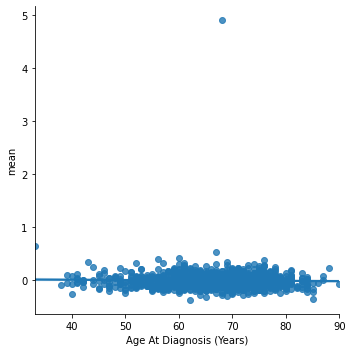

In [97]:
sns.lmplot(data=plot_df, x='Age At Diagnosis (Years)', y='mean')

# Clustering

## CNV

In [ ]:
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Strand = CNV.Strand.astype(str)
CNV['rnaID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x:
                                                                            "_".join(x), axis=1)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV.set_index('rnaID', inplace=True)
CNV_transpose = CNV.T

In [ ]:
CNV_transpose.reset_index().to_feather(ctype+'_CNV.feather')

In [ ]:
embedder_lle = LLE(n_components=2)
embedder_umap = UMAP(n_components=2)
embedder_iso = Isomap(n_components=2)

In [ ]:
embedder_lle.fit(CNV_transpose)
embed = embedder_lle.transform(CNV_transpose)
embed_lle_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_lle_cnv = embed_lle_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
embedder_umap.fit(CNV_transpose)
embed = embedder_umap.transform(CNV_transpose)
embed_umap_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_umap_cnv = embed_umap_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                   'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
embedder_iso.fit(CNV_transpose)
embed = embedder_iso.transform(CNV_transpose)
embed_iso_cnv = pd.DataFrame(data=embed, index=CNV_transpose.index, columns=['d0', 'd1'])
embed_iso_cnv = embed_iso_cnv.join(meta[['Stage', 'Tstage', 'Mstage', 
                                   'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
cat = 'Diagnosis'

fig, ax = plt.subplots(ncols=3, figsize=(19,7))
sns.scatterplot(data=embed_lle_cnv, x='d0', y='d1', alpha=0.7, ax=ax[0], hue=cat) #, palette='Spectral')
sns.scatterplot(data=embed_umap_cnv, x='d0', y='d1', alpha=0.7, ax=ax[1], hue=cat) #, palette='Spectral')
sns.scatterplot(data=embed_iso_cnv, x='d0', y='d1', alpha=0.7, ax=ax[2], hue=cat) #, palette='Spectral')

## Proteome

In [163]:
from sklearn.decomposition import NMF
from sklearn.impute import IterativeImputer, KNNImputer

impute_choice = 'iterative'
transformer, inv_transformer = np.exp, np.log

In [164]:
proteome_transposed =proteome.set_index('sample').T
if transformer is not None:
    proteome_transposed = transformer(proteome_transposed)

    
def impute_wrapper(X, impute_method='iterative'):
    if impute_method == 'iterative':    
        imputer = IterativeImputer(max_iter=50, verbose=2)
        dft = imputer.fit_transform(X)
        dft = pd.DataFrame(data=dft, index=X.index, columns=X.columns.tolist())
    elif impute_method == 'nmf':    
        # get rid of NaN's with NMF
        # https://codereview.stackexchange.com/questions/96725/imputing-values-with-non-negative-matrix-factorization
        mf_nmf= NMF(verbose=2)
        dft = X.copy()
        msk = np.argwhere(np.isnan(dft.values))
        dft.fillna(0, inplace=True)
        mf_nmf.fit(dft)
        while mf_nmf.reconstruction_err_**2 > 10:
            W = mf_nmf.fit_transform(dft.values)
            dft.values[~msk] = W.dot(mf_nmf.components_)[~msk]
            print(mf_nmf.reconstruction_err_)
    elif impute_method == 'knn':
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        dft = imputer.fit_transform(X)
        dft = pd.DataFrame(data=dft, index=X.index, columns=X.columns.tolist())        
    return dft

In [ ]:
dft = impute_wrapper(proteome_transposed, impute_method=impute_choice)

In [ ]:
# patient clustering
pat_corr = dft.T.corr(method='spearman')
pat_cos = -(dft.T.corr(method=sc.spatial.distance.cosine)-1)

In [ ]:
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [ ]:
embedder_lle = LLE(n_components=2)

embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_lle_sim_proteome = embed_lle_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(dft)
embed = embedder_lle.transform(dft)
embed_lle_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_lle_proteome = embed_lle_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_iso = Isomap(n_components=2)

embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_sim_proteome = embed_iso_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(dft)
embed = embedder_iso.transform(dft)
embed_iso_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_proteome = embed_iso_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_umap = UMAP(n_components=2)

embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_sim_proteome = embed_umap_sim_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(dft)
embed = embedder_umap.transform(dft)
embed_umap_proteome = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_proteome = embed_umap_proteome.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_proteome, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_proteome, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_proteome, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_proteome, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors.fit(embed_lle_sim_proteome[['d0','d1']])

In [ ]:
# algo: take N nearestneighbors and use weighted average to replace NaN's
def nn_impute(X, msk, nnlist, nndist):
    for i,j in tqdm(msk):
        weights = 1/nndist[i]

        nbrs = list(nnlist[i])
        v = X.iloc[nbrs, j]
        nnanidx = np.argwhere(~np.array(np.isnan(v)))[:,0]    

        weights /=sum(weights[nnanidx])
        X.iloc[i, j] = np.sum(weights[nnanidx]*v[nnanidx])
    return X
msk = np.argwhere(np.isnan(proteome_transposed.values))
proteome_transposed = nn_impute(proteome_transposed, msk,neighbors.kneighbors()[1], neighbors.kneighbors()[0])

In [ ]:
if inv_transformer is not None:
    proteome_transposed = inv_transformer(proteome_transposed)

In [ ]:
proteome_transposed.iloc[:, random.sample(range(100), 5)].plot.kde()

In [ ]:
proteome_transposed.reset_index().to_feather(ctype+"_proteome.feather")

## miRNA

In [ ]:
miRNA = miRNA.loc[:, miRNA.columns[miRNA.isna().sum()<300]]

In [ ]:
miRNA_imputed = impute_wrapper(miRNA, impute_method='knn')

In [ ]:
miRNAcorr = pd.np.triu(miRNA_imputed.corr().values)
np.fill_diagonal(miRNAcorr, 0)

# idiot-way of removing collinearity
cols_to_delete = []
for corr_pair in [tuple(a) for a in list(np.argwhere(miRNAcorr>0.99))]:
    cols_to_delete.append(miRNA_imputed.columns[corr_pair[0]])

In [ ]:
miRNA_imputed.drop(cols_to_delete, axis=1, inplace=True)

In [ ]:
# patient clustering
pat_corr = miRNA_imputed.T.corr(method='spearman')
pat_cos = -(miRNA_imputed.T.corr(method=sc.spatial.distance.cosine)-1)
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [ ]:
embedder_lle = LLE(n_components=2)
embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_sim_mirna = embed_lle_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(miRNA_imputed)
embed = embedder_lle.transform(miRNA_imputed)
embed_lle_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_mirna = embed_lle_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_sim_mirna = embed_iso_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(miRNA_imputed)
embed = embedder_iso.transform(miRNA_imputed)
embed_iso_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_mirna = embed_iso_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])


embedder_umap = UMAP(n_components=2)
embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_mirna = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_umap_sim_mirna = embed_umap_sim_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(miRNA_imputed)
embed = embedder_umap.transform(miRNA_imputed)
embed_umap_mirna = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_mirna = embed_umap_mirna.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_mirna, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_mirna, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_mirna, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_mirna, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')


In [ ]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors.fit(embed_umap_sim_mirna[['d0','d1']])

In [ ]:
# algo: take N nearestneighbors and use weighted average to replace NaN's
def nn_impute(X, msk, nnlist, nndist):
    for i,j in tqdm(msk):
        weights = 1/nndist[i]

        nbrs = list(nnlist[i])
        v = X.iloc[nbrs, j]
        nnanidx = np.argwhere(~np.array(np.isnan(v)))[:,0]    

        weights /=sum(weights[nnanidx])
        X.iloc[i, j] = np.sum(weights[nnanidx]*v[nnanidx])
    return X

msk = msk = np.argwhere(np.isnan(miRNA.values))
miRNA_imputed = nn_impute(miRNA_imputed, msk,neighbors.kneighbors()[1], neighbors.kneighbors()[0])

In [ ]:
nancols = np.unique(msk[:,1])
#rrange = nancols[random.sample(range(len(nancols)), 5)]
miRNA.iloc[:, nancols].mean().plot.kde(label='withNaNs')
miRNA_imputed.iloc[:, nancols].mean().plot.kde(label='withoutNaNs')
plt.legend()

In [ ]:
miRNA_imputed.reset_index().to_feather(ctype+"_mRNA.feather")

## RNA expression

In [98]:
RNAex = ds['RNAex']
del ds
gc.collect()
RNAex_T = RNAex.T

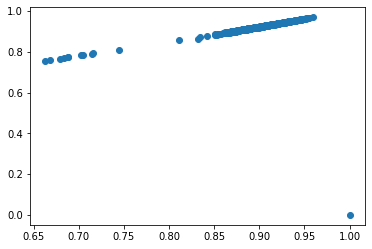

In [99]:
# patient clustering
pat_corr = RNAex_T.corr(method='pearson')
pat_cos = -(RNAex_T.corr(method=sc.spatial.distance.cosine)-1)
plt.scatter(pat_corr.iloc[:,0], pat_cos.iloc[:,0])

In [ ]:
_, ir, jr = iterative_correlator(RNAex.values, min_corr=0.95, axis=0)

In [ ]:
RNAex_corr = pd.np.triu(RNAex.iloc[:,set(ir+jr)].corr().values)
np.fill_diagonal(RNAex_corr, 0)

# sub-optimal-way of removing collinearity
cols_to_delete = []
for corr_pair in [tuple(a) for a in list(np.argwhere(RNAex_corr>0.99))]:
    print(corr_pair)
    cols_to_delete.append(RNAex.columns[corr_pair[0]])

In [ ]:
RNAex.drop(cols_to_delete, axis=1, inplace=True)

In [124]:
RNAex.reset_index().to_feather(ctype+"_RNAex.feather")

In [ ]:
embedder_lle = LLE(n_components=2)
embedder_lle.fit(pat_corr)
embed = embedder_lle.transform(pat_corr)
embed_lle_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_sim_rnaex = embed_lle_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_lle.fit(RNAex)
embed = embedder_lle.transform(RNAex)
embed_lle_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_lle_rnaex = embed_lle_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(pat_corr)
embed = embedder_iso.transform(pat_corr)
embed_iso_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_iso_sim_rnaex = embed_iso_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso.fit(RNAex)
embed = embedder_iso.transform(RNAex)
embed_iso_rnaex  = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_iso_rnaex  = embed_iso_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])



embedder_umap = UMAP(n_components=2)
embedder_umap.fit(pat_corr)
embed = embedder_umap.transform(pat_corr)
embed_umap_sim_rnaex = pd.DataFrame(data=embed, index=pat_corr.index, columns=['d0', 'd1'])
embed_umap_sim_rnaex = embed_umap_sim_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap.fit(RNAex)
embed = embedder_umap.transform(RNAex)
embed_umap_rnaex = pd.DataFrame(data=embed, index=pat_cos.index, columns=['d0', 'd1'])
embed_umap_rnaex = embed_umap_rnaex.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(27,14))

cat = 'Diagnosis'
sns.scatterplot(data=embed_lle_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[0,0])
sns.scatterplot(data=embed_lle_rnaex, x='d0', y='d1', hue=cat, ax=ax[0,1])
sns.scatterplot(data=embed_iso_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[1,0])
sns.scatterplot(data=embed_iso_rnaex, x='d0', y='d1', hue=cat, ax=ax[1,1])
sns.scatterplot(data=embed_umap_sim_rnaex, x='d0', y='d1', hue=cat, ax=ax[2,0])
sns.scatterplot(data=embed_umap_rnaex, x='d0', y='d1', hue=cat, ax=ax[2,1])

ax[0,1].set_title('LLE on features')
ax[0,0].set_title('LLE on similarities')
ax[1,1].set_title('isomap on features')
ax[1,0].set_title('isomap on similarities')
ax[2,1].set_title('UMAP on features')
ax[2,0].set_title('UMAP on similarities')

## Mutation

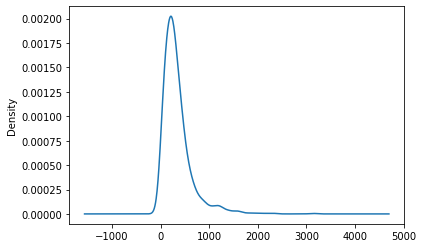

In [13]:
mutation.groupby('Sample_ID').Gene.nunique().plot.kde()

In [28]:
mutation

,Sample_ID,Gene,Chr,Start,Stop,Ref,Alt,Amino_Acid_Change,Effect
0,TCGA-49-4490-01,UBR4,chr1,19155452,19155452,C,T,p.E2097K,missense_variant
1,TCGA-49-4490-01,PLA2G2D,chr1,20115562,20115562,G,A,p.C79C,synonymous_variant
2,TCGA-49-4490-01,MTF1,chr1,37822366,37822366,A,G,p.S508P,missense_variant
3,TCGA-49-4490-01,CLCA2,chr1,86443922,86443922,G,A,p.D542N,missense_variant
4,TCGA-49-4490-01,WNT2B,chr1,112525957,112525957,G,C,NaN,downstream_gene_variant
...,...,...,...,...,...,...,...,...,...
389291,TCGA-85-8353-01,MAGEB1,chrX,30250548,30250548,C,A,p.R19R,synonymous_variant
389292,TCGA-85-8353-01,CFAP47,chrX,35975819,35975819,T,A,p.V873V,synonymous_variant
389293,TCGA-85-8353-01,ALAS2,chrX,55021208,55021208,G,T,p.T161N,missense_variant
389294,TCGA-85-8353-01,KIAA2022,chrX,74739410,74739410,T,C,p.I1516V,missense_variant


In [27]:
#mutation.groupby('Sample_ID').Effect.value_counts().groupby('Effect').agg(lambda x: sum(x>0))['frameshift_variant']

1029

In [132]:
# per Sample ID, per gene: # number of mutations
# TODO: EffectMain -> needs to be collapsed into a few main mutation types
# TODO: GeneOnto -> Gene ontology needs to be added, Gene mutations are too dispersed
# if we have the molecular function, biological process and cellular component for each gene 
# we can create informative graphs
mutation.set_index('Sample_ID', inplace=True)
mutation_merged = mutation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [133]:
mutation = mutation.loc[mutation.Gene!='Unknown']
mutation = mutation.loc[mutation.Gene!='Y_RNA']
mutation = mutation.loc[mutation.Gene!='Metazoa_SRP']

In [134]:
tmp = pd.DataFrame(mutation_merged[['Diagnosis', 'Gender', 'Gene']].groupby(['Diagnosis', 'Gender', 'Gene']).size())
tmp.columns = ['mutation_count']
tmp.reset_index(inplace=True)

In [135]:
tmp_LA_male = tmp.loc[(tmp.Diagnosis=='Lung Adenocarcinoma') & (tmp.Gender==0.0)]
tmp_LA_female = tmp.loc[(tmp.Diagnosis=='Lung Adenocarcinoma') & (tmp.Gender==1.0)]
tmp_LSCC_male = tmp.loc[(tmp.Diagnosis=='Lung Squamous Cell Carcinoma') & (tmp.Gender==0.0)]
tmp_LSCC_female = tmp.loc[(tmp.Diagnosis=='Lung Squamous Cell Carcinoma') & (tmp.Gender==1.0)]

In [136]:
tmp_LSCC_male.sort_values(by='mutation_count', ascending=False)[:100]

,Diagnosis,Gender,Gene,mutation_count
50372,Lung Squamous Cell Carcinoma,0.0,TTN,908
43347,Lung Squamous Cell Carcinoma,0.0,MUC16,355
49935,Lung Squamous Cell Carcinoma,0.0,TP53,329
37216,Lung Squamous Cell Carcinoma,0.0,CSMD3,286
47243,Lung Squamous Cell Carcinoma,0.0,RYR2,231
49025,Lung Squamous Cell Carcinoma,0.0,SYNE1,228
42237,Lung Squamous Cell Carcinoma,0.0,LRP1B,201
50671,Lung Squamous Cell Carcinoma,0.0,USH2A,201
51273,Lung Squamous Cell Carcinoma,0.0,ZFHX4,189
38724,Lung Squamous Cell Carcinoma,0.0,FAM135B,145


In [137]:
tmp_LSCC_female.sort_values(by='mutation_count', ascending=False)[:100]

,Diagnosis,Gender,Gene,mutation_count
64706,Lung Squamous Cell Carcinoma,1.0,TTN,298
59311,Lung Squamous Cell Carcinoma,1.0,MUC16,99
64380,Lung Squamous Cell Carcinoma,1.0,TP53,95
62340,Lung Squamous Cell Carcinoma,1.0,RYR2,86
54617,Lung Squamous Cell Carcinoma,1.0,CSMD3,83
58500,Lung Squamous Cell Carcinoma,1.0,LRP1B,74
64921,Lung Squamous Cell Carcinoma,1.0,USH2A,67
65388,Lung Squamous Cell Carcinoma,1.0,ZFHX4,66
63721,Lung Squamous Cell Carcinoma,1.0,SYNE1,62
65220,Lung Squamous Cell Carcinoma,1.0,XIRP2,55


We have to be aware that each gene can consist of more or less base pairs. The most mutated gene is TTN or Titin, which is also the **largest** gene in terms of number of exons and the gene containing the largest single exon (of 17,106 bp).  (less importantly but interesting nonetheless, the TTN proteine encoded by the gene is also the largest known protein).

A simple mitigation of this confounder is the inclusion of the sequence length per gene.

In [138]:
rnamap['genome_length'] = rnamap['Stop'].astype(int)- rnamap['Start'].astype(int) 

In [139]:
mutation['mutation_length'] = mutation['Stop'] - mutation['Start']

In [140]:
mutlength = mutation[['Gene', 'Start']].groupby('Gene').agg('max')-mutation[['Gene', 'Start']].groupby('Gene').agg('min')
mutlength.columns=['total_mutation_length']
mutation = mutation.merge(mutlength, left_on='Gene', right_index=True, how='left')
genelength= pd.DataFrame(rnamap.groupby('Gene').genome_length.sum())
mutation = mutation.merge(genelength, left_on='Gene', right_index=True, how='left')

In [141]:
mutation

,Gene,Chr,Start,Stop,Ref,Alt,Amino_Acid_Change,Effect,mutation_length,total_mutation_length,genome_length
Sample_ID,,,,,,,,,,,
TCGA-49-4490-01,UBR4,chr1,19155452,19155452,C,T,p.E2097K,missense_variant,0,124026,135770.0
TCGA-49-4490-01,PLA2G2D,chr1,20115562,20115562,G,A,p.C79C,synonymous_variant,0,1480,7627.0
TCGA-49-4490-01,MTF1,chr1,37822366,37822366,A,G,p.S508P,missense_variant,0,42393,50053.0
TCGA-49-4490-01,CLCA2,chr1,86443922,86443922,G,A,p.D542N,missense_variant,0,31374,32472.0
TCGA-49-4490-01,WNT2B,chr1,112525957,112525957,G,C,NaN,downstream_gene_variant,0,34929,63624.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-8353-01,MAGEB1,chrX,30250548,30250548,C,A,p.R19R,synonymous_variant,0,1168,8308.0
TCGA-85-8353-01,CFAP47,chrX,35975819,35975819,T,A,p.V873V,synonymous_variant,0,225188,NaN
TCGA-85-8353-01,ALAS2,chrX,55021208,55021208,G,T,p.T161N,missense_variant,0,16849,22009.0


In [142]:
mutation.index[(mutation.total_mutation_length/mutation.genome_length)>100]

Index(['TCGA-44-A47A-01', 'TCGA-53-7624-01', 'TCGA-17-Z011-01', 'TCGA-49-6743-01', 'TCGA-62-A471-01', 'TCGA-55-7907-01', 'TCGA-50-5049-01', 'TCGA-75-6214-01', 'TCGA-75-6214-01', 'TCGA-MN-A4N4-01', 'TCGA-MP-A4TK-01', 'TCGA-95-A4VN-01', 'TCGA-50-5930-01', 'TCGA-L9-A444-01', 'TCGA-55-8090-01', 'TCGA-44-A47G-01', 'TCGA-05-4398-01', 'TCGA-50-5044-01', 'TCGA-17-Z062-01', 'TCGA-55-A490-01', 'TCGA-55-8203-01', 'TCGA-55-8089-01', 'TCGA-90-7964-01', 'TCGA-63-A5M9-01', 'TCGA-63-A5M9-01', 'TCGA-37-3792-01', 'TCGA-43-6770-01', 'TCGA-43-6770-01', 'TCGA-58-A46M-01', 'TCGA-77-7465-01', 'TCGA-58-8391-01', 'TCGA-63-A5MM-01', 'TCGA-43-2581-01', 'TCGA-56-7731-01', 'TCGA-22-4594-01', 'TCGA-51-6867-01', 'TCGA-60-2726-01', 'TCGA-85-8277-01', 'TCGA-34-2609-01', 'TCGA-56-7221-01', 'TCGA-85-8350-01'], dtype='object', name='Sample_ID')

In [143]:
tmp = pd.DataFrame(mutation_merged[['Diagnosis', 'Gender', 'Gene']].groupby(['Diagnosis', 'Gender', 'Gene']).size())
tmp.columns = ['mutation_count']
tmp.reset_index(inplace=True)
tmp = tmp.merge(mutation.groupby('Gene').genome_length.mean(), left_on='Gene', right_index=True, how='left')
tmp['rel_mutation'] = (tmp.mutation_count/tmp.genome_length)

In [144]:
tmp.sort_values(by='rel_mutation', ascending=False)[:20]

,Diagnosis,Gender,Gene,mutation_count,genome_length,rel_mutation
42891,Lung Squamous Cell Carcinoma,0.0,MIR1270,12,82.0,0.146341
33852,Lung Squamous Cell Carcinoma,0.0,AC011467.1,10,82.0,0.121951
48374,Lung Squamous Cell Carcinoma,0.0,SNORD115-8,9,81.0,0.111111
134,Lung Adenocarcinoma,0.0,AC090825.1,9,82.0,0.109756
17046,Lung Adenocarcinoma,1.0,AC090825.1,9,82.0,0.109756
48359,Lung Squamous Cell Carcinoma,0.0,SNORD115-30,8,81.0,0.098765
34304,Lung Squamous Cell Carcinoma,0.0,AL391261.1,9,92.0,0.097826
33872,Lung Squamous Cell Carcinoma,0.0,AC090825.1,8,82.0,0.097561
25492,Lung Adenocarcinoma,1.0,MIR6511A3,6,66.0,0.090909
17462,Lung Adenocarcinoma,1.0,AL391261.1,8,92.0,0.086957


In [145]:
# missense_variant, frameshift_variant, 5_prime_UTR_variant,
# 3_prime_UTR_variant, inframe_deletion, inframe_insertion
# upstream_gene_variant, downstream_gene_variant

variants = {0: 'missense_variant', 
            1: 'frameshift_variant',
            2: '5_prime_UTR_variant',
            2: '3_prime_UTR_variant',
            3: 'inframe_deletion',
            3: 'inframe_insertion',
            4: 'upstream_gene_variant',
            4: 'downstream_gene_variant'}

def replace_mutation(x):
    for k,v in variants.items():
        if v in x:
            return k
mutation.Effect = mutation.Effect.apply(replace_mutation)
mutation.dropna(subset=['Effect'], axis=0, inplace=True)
mutation.drop(['Amino_Acid_Change', 'Start', 'Stop', 'Chr', 
               'Ref', 'Alt', 'mutation_length', 'total_mutation_length',
               'genome_length'], axis=1, inplace=True)
mutation.Effect = mutation.Effect.astype(int)
mutation.reset_index(inplace=True)
mutation['One'] = 1

In [146]:
mutation_pivot = dict()

In [147]:
mutation_pivot['missense_variant'] = mutation.loc[mutation.Effect==0, :].pivot_table(index='Sample_ID',
                                                          values='One', columns='Gene', aggfunc='mean')

mutation_pivot['frameshift_variant'] = mutation.loc[mutation.Effect==1, :].pivot_table(index='Sample_ID',
                                                          values='One', columns='Gene', aggfunc='mean')

mutation_pivot['prime_UTR_variant'] = mutation.loc[mutation.Effect==2, :].pivot_table(index='Sample_ID',
                                                          values='One', columns='Gene', aggfunc='mean')

mutation_pivot['inframe_delta'] = mutation.loc[mutation.Effect==3, :].pivot_table(index='Sample_ID',
                                                          values='One', columns='Gene', aggfunc='mean')

mutation_pivot['updownstream_gene_variant'] = mutation.loc[mutation.Effect==4, :].pivot_table(index='Sample_ID',
                                                          values='One', columns='Gene', aggfunc='mean')


In [148]:
# very sparse!
# require a minimum of 50 patients with mutations for each gene
for k in mutation_pivot.keys():
    mutation_pivot[k] = mutation_pivot[k].loc[:,mutation_pivot[k].columns[((mutation_pivot[k].shape[0] - 
                                                    mutation_pivot[k].isna().sum())>25)]]
    
for k in mutation_pivot.keys():
    mutation_pivot[k] = mutation_pivot[k].fillna(-1)

In [149]:
mutation_pivot_joined = mutation_pivot['missense_variant'].join(mutation_pivot['frameshift_variant'], rsuffix='_frame')\
                                                          .join(mutation_pivot['prime_UTR_variant'], rsuffix='_UTR')\
                                                          .join(mutation_pivot['inframe_delta'], rsuffix='_inframe')\
                                                          .join(mutation_pivot['updownstream_gene_variant'], rsuffix='_updown')
mutation_pivot_joined.fillna(-1, inplace=True)

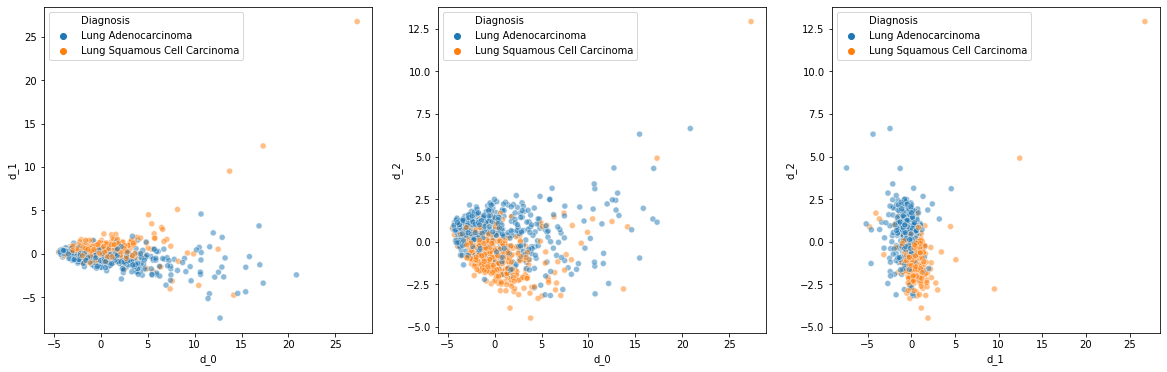

In [150]:
dims = 3
df_toreduce = mutation_pivot['missense_variant'] # mutation_pivot_joined
reducer = PCA(n_components=dims)
reducer.fit(df_toreduce)
plot_df = pd.DataFrame(data=reducer.transform(df_toreduce),
                       index=df_toreduce.index,
                       columns=['d_'+str(i) for i in range(dims)])
plot_df = plot_df.join(meta[['Diagnosis', 'Response']])

fig, ax = plt.subplots(ncols=3, figsize=(20,6))
sns.scatterplot(data=plot_df, x='d_0', y='d_1', hue='Diagnosis', alpha=0.5, ax=ax[0])
sns.scatterplot(data=plot_df, x='d_0', y='d_2', hue='Diagnosis', alpha=0.5, ax=ax[1])
sns.scatterplot(data=plot_df, x='d_1', y='d_2', hue='Diagnosis', alpha=0.5, ax=ax[2])

In [152]:
plot_df[['d_0', 'd_1', 'd_2']].reset_index().to_feather(ctype+'_mutation.feather')

We have high degree of sparsity (that we ducktape with ```.fillna(0)```. To reduce it we can do several things:
* group by part of name: ```A2ML1, A2M : A2M```
* biological pathways
* chr#, bp range

Proteomics-mapping would be a bad idea because a gene can (co-)code for multiple proteines, we do not want
more labels, we want **less**!

In [153]:
import re
no_numbers_count = len(set([re.sub(r'[0-9]+', '', c) for c in mutation_pivot['missense_variant'].columns]))
first_three_chars = len(set([c[:3] for c in mutation_pivot['missense_variant'].columns]))

In [154]:
pathways = defaultdict(list)
with open('../pathways/ReactomePathways.gmt') as f:
    lines = f.read().split("\n")
    
    for line in lines:
        seps = line.split("\t")
        pathways[seps[0].replace(" ","_")] = [s.lower() for s in seps[1:]]

In [155]:
mutation_pivot['missense_variant'].columns[mutation_pivot['missense_variant'].mean()>-0.8]

Index(['ABCA13', 'ADAMTS12', 'ADGRB3', 'ADGRG4', 'AHNAK2', 'ANK2', 'APOB', 'BRINP3', 'CACNA1E', 'CDH10', 'CNTNAP2', 'CNTNAP5', 'COL11A1', 'COL22A1', 'COL6A3', 'CPS1', 'CSMD1', 'CSMD2', 'CSMD3', 'CUBN', 'DMD', 'DNAH11', 'DNAH5', 'DNAH7', 'DNAH8', 'DNAH9', 'ERICH3', 'FAM135B', 'FAT3', 'FAT4', 'FBN2', 'FLG', 'HCN1', 'HERC2', 'HMCN1', 'KEAP1', 'KRAS', 'LRP1B', 'LRP2', 'LRRC7', 'MUC16', 'MUC17', 'MYH2', 'NAV3', 'NPAP1', 'NRXN1', 'OBSCN', 'PAPPA2', 'PCDH11X', 'PCDH15', 'PCLO', 'PEG3', 'PKHD1', 'PKHD1L1', 'PTPRD', 'PXDNL', 'RELN', 'RP1L1', 'RYR1', 'RYR2', 'RYR3', 'SI', 'SORCS1', 'SPHKAP', 'SPTA1', 'SSPO', 'SYNE1', 'TENM1', 'TNN', 'TNR', 'TP53', 'TTN', 'USH2A', 'XIRP2', 'ZFHX4', 'ZNF536', 'ZNF804A', 'ZNF804B'], dtype='object', name='Gene')

In [156]:
pathways_mutations = defaultdict(list)
for _gene in mutation_pivot['missense_variant']:
    pathways_mutations[_gene].extend([k for k, v in pathways.items() if _gene.lower() in v])

In [157]:
len(set([_v for v in pathways_mutations.values()
        for _v in v]))

1462

## Methylation

In [158]:
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'],inplace=True, axis=1)
methylation.set_index('probeID', inplace=True)
keep_cols = methylation.index[methylation.isna().sum(axis=1)<400]
methylation = methylation.loc[keep_cols]
methylation_T = methylation.T

In [165]:
# impute
methylation_T = impute_wrapper(methylation_T, impute_method='knn')

In [166]:
decomp_pca = PCA(n_components=100)

In [167]:
decomp_pca.fit(methylation_T)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

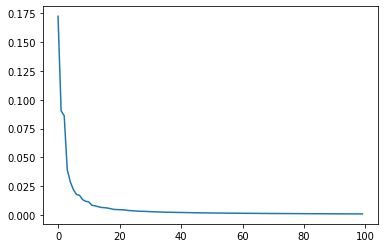

In [168]:
plt.plot(decomp_pca.explained_variance_ratio_)

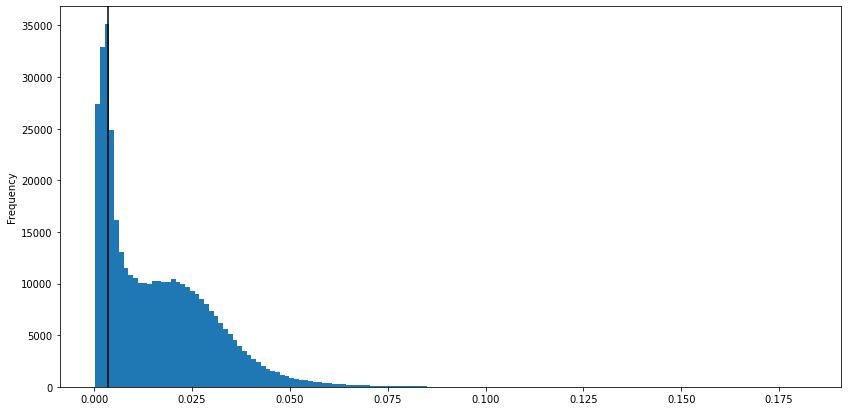

In [169]:
methyl_var = (methylation_T.var()/(methylation_T.max()-methylation_T.min()))
methyl_var.plot.hist(bins=150, figsize=(14,7))
plt.axvline(0.0035, color='black')

In [170]:
keep_cols = methylation_T.columns[methyl_var>0.0035].tolist()
methylation_T = methylation_T.loc[:,keep_cols]

In [ ]:
embedder_pca = PCA(n_components=2)
embedder_lle.fit(methylation_T)
embed = embedder_pca.transform(methylation_T)
embed_pca_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_pca_methylation = embed_pca_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_iso = Isomap(n_components=2)
embedder_iso.fit(methylation_T)
embed = embedder_iso.transform(methylation_T)
embed_iso_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_iso_methylation = embed_iso_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap = UMAP(n_components=2)
embedder_umap.fit(methylation_T)
embed = embedder_umap.transform(methylation_T)
embed_umap_methylation = pd.DataFrame(data=embed, index=methylation_T.index, columns=['d0', 'd1'])
embed_umap_methylation = embed_umap_methylation.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(19,7))

cat = 'Diagnosis' # Gender
sns.scatterplot(data=embed_pca_methylation, x='d0', y='d1', hue=cat, ax=ax[0])
sns.scatterplot(data=embed_iso_methylation, x='d0', y='d1', hue=cat, ax=ax[1])
sns.scatterplot(data=embed_umap_methylation, x='d0', y='d1', hue=cat, ax=ax[2])

ax[0].set_title('PCA on features')
ax[1].set_title('Isomap on features')
ax[2].set_title('UMAP on features')


In [172]:
methylation_T.reset_index().to_feather(ctype+'_methylation.feather')

In [199]:
plot_df = meta.loc[~meta['Age At Diagnosis (Years)'].isna(), ['Age At Diagnosis (Years)']].join(methylation_T, how='inner')

In [200]:
Y_age = plot_df['Age At Diagnosis (Years)']
plot_df.drop('Age At Diagnosis (Years)', axis=1, inplace=True)

In [202]:
age_methyl_correlations_raw = omic_helpers.pearson_scores(plot_df,Y_age, return_df=True, correction='bonferroni')

In [205]:
methyl_correlations_zscore = omic_helpers.pearson_scores(StandardScaler().fit_transform(plot_df),
                                                             Y_age, 
                                                             return_df=True, 
                                                             correction='bonferroni')

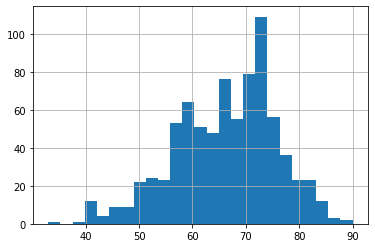

In [244]:
Y_age.hist(bins=25)

Text(0.5, 1.0, 'Methylation - Age, Pearson scores')

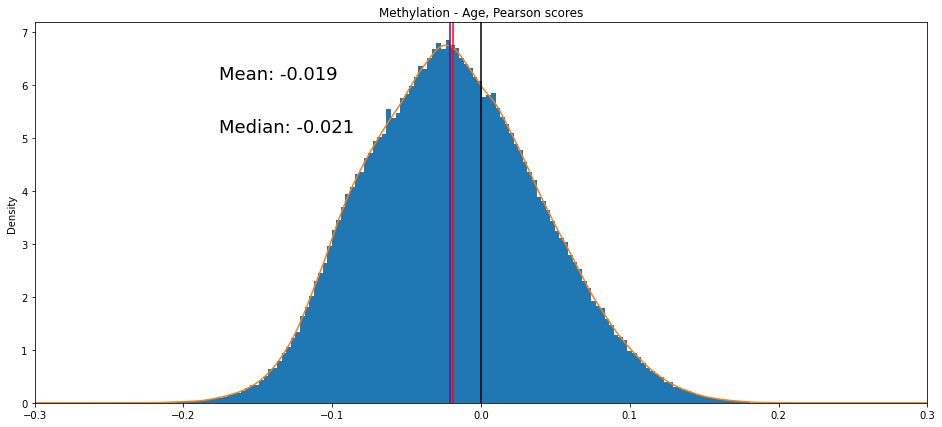

In [234]:
fig, ax = plt.subplots(figsize=(16,7))
age_methyl_correlations_raw.pearson_score.hist(bins=150, density=True)
age_methyl_correlations_raw.pearson_score.plot.kde()
ax.axvline(0, color='black')
ax.axvline(-0.019, color='red')
ax.axvline(-0.021, color='purple')
ax.set_xlim(-0.3,0.3)
ax.text(s='Mean: -0.019', x=-0.176, y=6.1, fontsize=18)
ax.text(s='Median: -0.021', x=-0.176, y=5.1, fontsize=18)
ax.set_title('Methylation - Age, Pearson scores')


# Multi-omic clustering

https://github.com/rmarkello/snfpy

In [ ]:
dimensions = {'rnaex': 5, 'methylation': 10, 'cnv': 3, 'proteomic': 3, 'mirna': 3}

momic = embed_umap_rnaex.join(embed_umap_methylation, rsuffix='_meth')
momic = momic.join(embed_umap_cnv, rsuffix='_cnv')
momic = momic.join(embed_umap_mirna, rsuffix='_mirna')
momic = momic.join(embed_umap_proteome, rsuffix='_prot')
momic.rename(index=str, columns={'d0':'d0_rnaex', 'd1': 'd1_rnaex'}, inplace=True)

In [ ]:
d_cols = [c for c in momic.columns if ('d0_' in c) or  ('d1_' in c)]

In [ ]:
momic_imputed = impute_wrapper(momic[d_cols], impute_method='iterative')

In [ ]:
# recombiner: div/multi/add
momic_recombined = recombiner(momic_imputed) 

In [ ]:
# fuzzy c-clustering

In [ ]:
embedder_iso = Isomap(n_components=2)
embedder_iso.fit(momic_imputed)
embed = embedder_iso.transform(momic_imputed)
embed_iso_momic = pd.DataFrame(data=embed, index=momic_imputed.index, columns=['d0', 'd1'])
embed_iso_momic = embed_iso_momic.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

embedder_umap = UMAP(n_components=2)
embedder_umap.fit(momic_imputed)
embed = embedder_umap.transform(momic_imputed)
embed_umap_momic = pd.DataFrame(data=embed, index=momic_imputed.index, columns=['d0', 'd1'])
embed_umap_momic = embed_umap_momic.join(meta[['Stage', 'Tstage', 'Mstage', 
                                 'Nstage', 'Response', 'Smoking', 'Gender', 'Diagnosis']])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(19,7))

cat = 'Response' # Gender
sns.scatterplot(data=embed_iso_momic, x='d0', y='d1', hue=cat, ax=ax[0], alpha=0.5)
sns.scatterplot(data=embed_umap_momic, x='d0', y='d1', hue=cat, ax=ax[1], alpha=0.5)

ax[0].set_title('Isomap on features')
ax[1].set_title('UMAP on features')

## Sparse CCA

In [ ]:
## concensus clustering, correspondence analysis, sparse supervised CCA, supervised PCA,
## Co-inertia analysis, MOFA, SNF, Concensus PCA, joint NMF

## https://www.sciencedirect.com/science/article/abs/pii/S0031320310005819

# Differential analysis for overall stage

## RNA

In [ ]:
# Stage, time_to_death, time_to_survival, time_to_relapse

In [ ]:
meta['time_to_death'] = np.nan
meta.loc[meta['Overall Survival Status']==1, 'time_to_death'] = meta['Time To Overall Survival (Days)']

meta['time_to_relapse'] = np.nan
meta.loc[meta['Relapse Status']==1, 'time_to_relapse'] = meta['Time To Relapse From Diagnosis (Days)']

meta['time_to_survival'] = np.nan
meta.loc[meta['Overall Survival Status']==0, 'time_to_survival'] = meta['Time To Overall Survival (Days)']

In [ ]:
target = 'Stage'
X = ds['RNAex'].join(meta[[target]], how='inner')

In [ ]:
X.dropna(subset=[target], inplace=True)
Y = X[[target]]
X.drop([target], axis=1, inplace=True)

In [ ]:
lincorr_dict = dict()
print("Spearman correlations")
lincorr_dict['spearman']= omic_helpers.spearman_scores(X,Y[target], return_df=True, correction='bonferroni')
print("Pearson correlations")
lincorr_dict['pearson']= omic_helpers.pearson_scores(X,Y[target], return_df=True, correction='bonferroni')
if include_alt_corrs:
    print("Monotonic aligned")
    lincorr_dict['monotonic_aligned'] = omic_helpers.monotonic_alignment(X,Y[[target]], return_df=True)
    print("Distance correlation")
    lincorr_dict['distance_correlation'] = omic_helpers.distcorr(X, Y[[target]], per_column=True,
                                                             return_df=True, columns=['distance_correlation'])
#lincorr_dict['mine'] = omic_helpers.mic_scores(X, Y[target], return_df=True)
lincorr = pd.concat(list(lincorr_dict.values()), axis=1)
lincorr.sort_values(by='spearman_pval', ascending=False, inplace=True)

In [ ]:
lincorr.dropna(inplace=True)
scores = lincorr.join(rnamap, how='inner')

In [ ]:
#scores.distance_correlation.plot.kde()
scores.pearson_score.plot.kde()
scores.spearman_score.plot.kde()

In [ ]:
# Interesting negative correlates
# AMY2B
# CBX7
# DAPK2
# GHRL
# LINC00852
# TTC21A
# FAM117A

## Methylation expression diff analysis for continuous Targets